 #  Performs the PCA analysis on the models obtained with different MEMs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import scipy.stats as stats

import statsmodels.stats.multitest as multi

from sklearn.decomposition import PCA
from itertools import permutations, product, combinations
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE

In [2]:
plt.rcParams.update({'font.size': 14})

Set the folder in which data are stored.

In [3]:
folder = "model_csv"

# Additional settings
Set the data you want to analyse and the labels to display with a dataset.

In [4]:
MEM_labels = {"INIT":"INIT", "TINIT":"tINIT", "GIMME":"GIMME", "IMAT":"iMAT"}
dataset_labels = {'NHBE':'HBE', 'LUNG':'Lung', '293T':'293T', 'CALU':'Calu-3', 'A549':'A549'}

order = {'MEM': ['iMAT', 'GIMME', 'INIT', 'tINIT'],
         'infection': ['healthy', 'infected'],
         'dataset': ['HBE', 'Lung', '293T', 'Calu-3', 'A549']}

In [5]:
#selected_MEM = ''
#selected_MEM = 'iMAT'
#selected_MEM = 'GIMME'
#selected_MEM = 'INIT'
selected_MEM = 'tINIT'


In [6]:
label_MEM = selected_MEM+"_" if selected_MEM else ""

# Metadata import
Read the data from the designated folder

In [7]:
models = [os.path.splitext(name)[0] for name in os.listdir(folder) if name.endswith('csv')]

In [8]:
len(models)

40

In [9]:
MEMs = list(set([model.split("_")[0] for model in models]))
infections = list(set([model.split("_")[2] for model in models]))
datasets = list(set([model.split("_")[3] for model in models]))

In [10]:
MEMs

['INIT', 'Gimme', 'IMAT', 'tINIT', 'iMAT']

In [11]:
datasets

['NHBE', '293T', 'Lung', 'A549', 'CALU']

In [12]:
infections

['I', 'H']

In [13]:
MEMs = {}
infections = {}
datasets = {}

model_MEMs = {}
model_infections = {}
model_datasets = {}

model_names = []
models_new = []

for i,model in enumerate(models):
    MEM = model.split("_")[0]
    MEM = MEM_labels[MEM.upper()]
                   
    infection = model.split("_")[2]
    infection = 'healthy' if infection == 'H' else 'infected'
    
    dataset = model.split("_")[3] 
    dataset = dataset_labels[dataset.upper()]  
    
    
    if selected_MEM and MEM != selected_MEM:
        continue
    
    if MEM not in MEMs:
        MEMs[MEM] = []
    if infection not in infections:
        infections[infection] = []
    if dataset not in datasets:
        datasets[dataset] = []

    model_name = f"{MEM}_{infection}_{dataset}"
    model_names.append(model_name)            
    
    models_new.append(model)
        
        
    MEMs[MEM].append(model_name)
    infections[infection].append(model_name)
    datasets[dataset].append(model_name)  
    
    model_MEMs[model_name] = MEM
    model_infections[model_name] = infection
    model_datasets[model_name] = dataset

models = models_new

In [14]:
if selected_MEM:
    groups = {"infection": infections, "dataset": datasets}
else:
    groups = {"MEM": MEMs, "infection": infections, "dataset": datasets}

# Model import and preprocessing

In [16]:
file_names = [model+".csv" for model in models]

In [17]:
df = pd.DataFrame(columns=['reaction_ID'])

for file_name in file_names:
    model_name = os.path.splitext(file_name)[0]    
    
    df2 = pd.read_csv(os.path.join(folder,file_name), sep=",")
    condition = (df2['lower_flux_bound'] < df2['upper_flux_bound'])# | ((df2['upper_flux_bound'] != 0) & (df2['lower_flux_bound'] != 0))    
    df2[model_name] = [1 if c == True else 0 for c in condition]
    df2 = df2[['reaction_ID', model_name]]
    
    df =  df.merge(df2, on='reaction_ID', how='outer')
df = df.fillna(0)

Prepare data for the analysis

In [19]:
M = np.transpose(df.values[:,1:])
M = M[:,~np.all(M==0, axis=0)]
M = M[:,~np.all(M==1, axis=0)]
M = StandardScaler(with_mean=True, with_std=False).fit_transform(M) #centering only

# PCA
Run the PCA analysis

In [20]:
n_components = 2

In [21]:
pca = PCA(n_components=n_components)
comps = pca.fit_transform(M)
df = pd.DataFrame(data = comps, columns = ['PC1', 'PC2'])
df['model'] = model_names

In [22]:
df_pca = pd.DataFrame()
df_pca = df_pca.append(pd.DataFrame(pca.explained_variance_).T)
df_pca = df_pca.append(pd.DataFrame(pca.explained_variance_ratio_).T)
df_pca.columns = ['PC1', 'PC2']
df_pca['label'] = ['explained variance', 'explained variance ratio']
df_pca = df_pca.set_index('label')
df_pca.to_csv("results_PCA\\"+"explained_variance"+label_MEM+".csv")

In [23]:
pca_explained = pca.explained_variance_ratio_

Plot the results

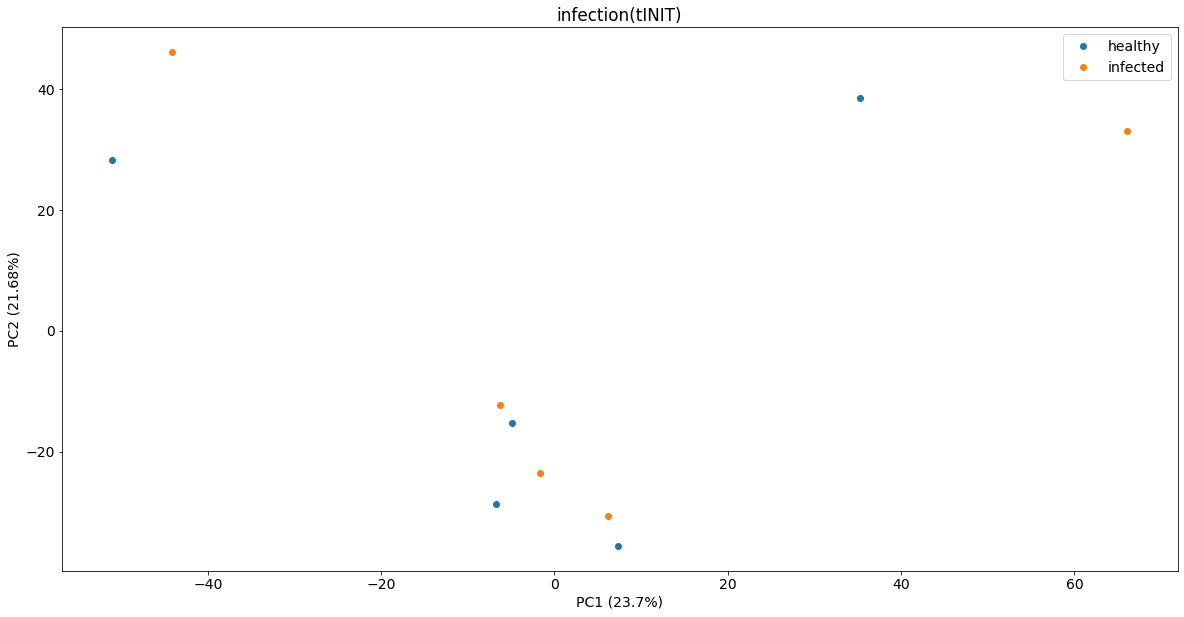

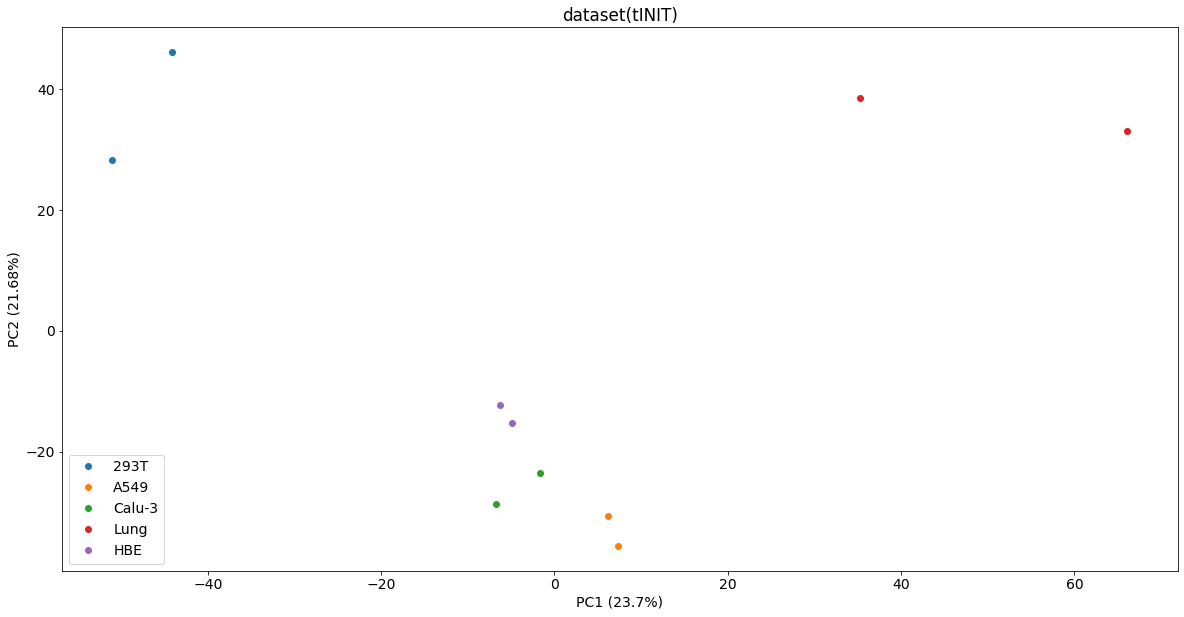

In [24]:
for c in combinations(range(n_components), 2):
    i1 = c[0]
    i2 = c[1]
    for factor in groups:
        for group, models_group in groups[factor].items():                        
            locs = np.isin(model_names, models_group)
            plt.plot(comps[locs,i1], comps[locs,i2],"o", label=group)
            
     
        if selected_MEM:
            plt.title(f'{factor}({selected_MEM})')
        else:
            plt.title(factor)
        plt.xlabel("PC"+str(i1+1) + " (" + str(round(100*pca_explained[i1],2))+"%)")
        plt.ylabel("PC"+str(i2+1) + " (" + str(round(100*pca_explained[i2],2))+"%)")
        plt.legend()
        plt.gcf().set_size_inches(20,10)
        plt.savefig("results_PCA\\PCA_"+label_MEM+"PC"+str(i1+1)+'_'+"PC"+str(i2+1)+'_'+factor+".pdf", format="pdf", bbox_inches = 'tight')
        #plt.savefig("results_PCA\\PCA_"+label_MEM+"PC"+str(i1+1)+'_'+"PC"+str(i2+1)+'_'+factor+".png", format="png", bbox_inches = 'tight')
        plt.show()
        

# Variance explanation
Calculate the explained variance within each principal component by each factor and store the results to a csv file

In [25]:
factors = list(groups.keys())
Rs = np.zeros((len(factors), 2))
rhos = np.zeros((len(factors), 2))


for ii, factor in enumerate(groups):
    scores1 = []
    scores2 = []
    #scores3 = []
    
    """for i in range(len(groups[factor])):
        idxs = np.array(np.where(np.isin(models, groups[factor][i])==True)).flatten()
        scores1.append(sorted(df.iloc[idxs, 0].values))
        scores2.append(sorted(df.iloc[idxs, 1].values))
        #scores3.append(sorted(df.iloc[idxs, 2].values))
    """
    for models_factor in groups[factor].values():
        idxs = np.array(np.where(np.isin(model_names, models_factor)==True)).flatten()
        scores1.append(sorted(df.iloc[idxs, 0].values))
        scores2.append(sorted(df.iloc[idxs, 1].values))
        #scores3.append(sorted(df.iloc[idxs, 2].values))
    
    for idx in permutations(range(len(scores1))):
        s1 = []
        s2 = []
        #s3 = []        
        for i in idx:
            s1 += scores1[i]
            s2 += scores2[i]
            #s3 += scores3[i]
            
        
        R_PC1 = pearsonr(np.arange(len(s1)), s1)[0]
        R_PC2 = pearsonr(np.arange(len(s2)), s2)[0]
        #R_PC3 = pearsonr(np.arange(len(s3)), s3)[0]

        rho_PC1 = spearmanr(np.arange(len(s1)), s1)[0]
        rho_PC2 = spearmanr(np.arange(len(s2)), s2)[0]
        #rho_PC3 = spearmanr(np.arange(len(s3)), s3)[0]

        Rs[ii, 0] = max(Rs[ii, 0], abs(R_PC1))
        Rs[ii, 1] = max(Rs[ii, 1], abs(R_PC2))
        #Rs[ii, 2] = max(Rs[ii, 2], abs(R_PC3))

        rhos[ii, 0] = max(rhos[ii, 0], abs(rho_PC1))
        rhos[ii, 1] = max(rhos[ii, 1], abs(rho_PC2))
        #rhos[ii, 2] = max(rhos[ii, 2], abs(rho_PC3))



In [26]:
groups

{'infection': {'healthy': ['tINIT_healthy_293T',
   'tINIT_healthy_A549',
   'tINIT_healthy_Calu-3',
   'tINIT_healthy_Lung',
   'tINIT_healthy_HBE'],
  'infected': ['tINIT_infected_293T',
   'tINIT_infected_A549',
   'tINIT_infected_Calu-3',
   'tINIT_infected_Lung',
   'tINIT_infected_HBE']},
 'dataset': {'293T': ['tINIT_healthy_293T', 'tINIT_infected_293T'],
  'A549': ['tINIT_healthy_A549', 'tINIT_infected_A549'],
  'Calu-3': ['tINIT_healthy_Calu-3', 'tINIT_infected_Calu-3'],
  'Lung': ['tINIT_healthy_Lung', 'tINIT_infected_Lung'],
  'HBE': ['tINIT_healthy_HBE', 'tINIT_infected_HBE']}}

In [27]:
Rs2 = Rs ** 2
#df_R2 = pd.DataFrame(data = Rs2, columns = ['R2(PC1)', 'R2(PC2)', 'R2(PC3)'])
df_R2 = pd.DataFrame(data = Rs2, columns = ['R2(PC1)', 'R2(PC2)'])
df_R2['factor'] = groups.keys()
df_R2=df_R2.set_index('factor')

In [28]:
df_R2

,R2(PC1),R2(PC2)
factor,,
infection,0.316271,0.294072
dataset,0.861129,0.878259


In [29]:
df_R2.to_csv("results_PCA\\"+"variability_explained"+label_MEM+".csv")

# t-SNE
Performs the t-SNE analysis and visualises the results.

In [30]:
if selected_MEM:
    perplexity = 5
else:
    perplexity = 15

In [31]:
tSNE = TSNE(n_components=n_components, perplexity = perplexity,  n_iter=5000)
comps = tSNE.fit_transform(M)
#df = pd.DataFrame(data = comps, columns = ['PC1', 'PC2', 'PC3'][:n_components])
df = pd.DataFrame(data = comps, columns = ['PC1', 'PC2'][:n_components])
df['model'] = model_names

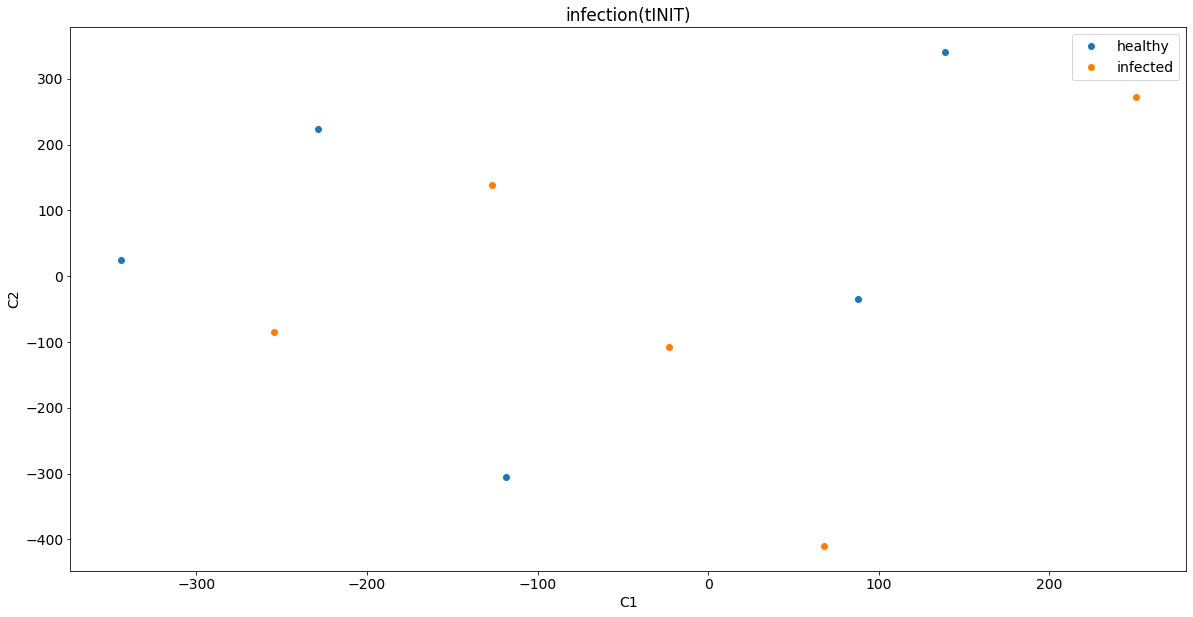

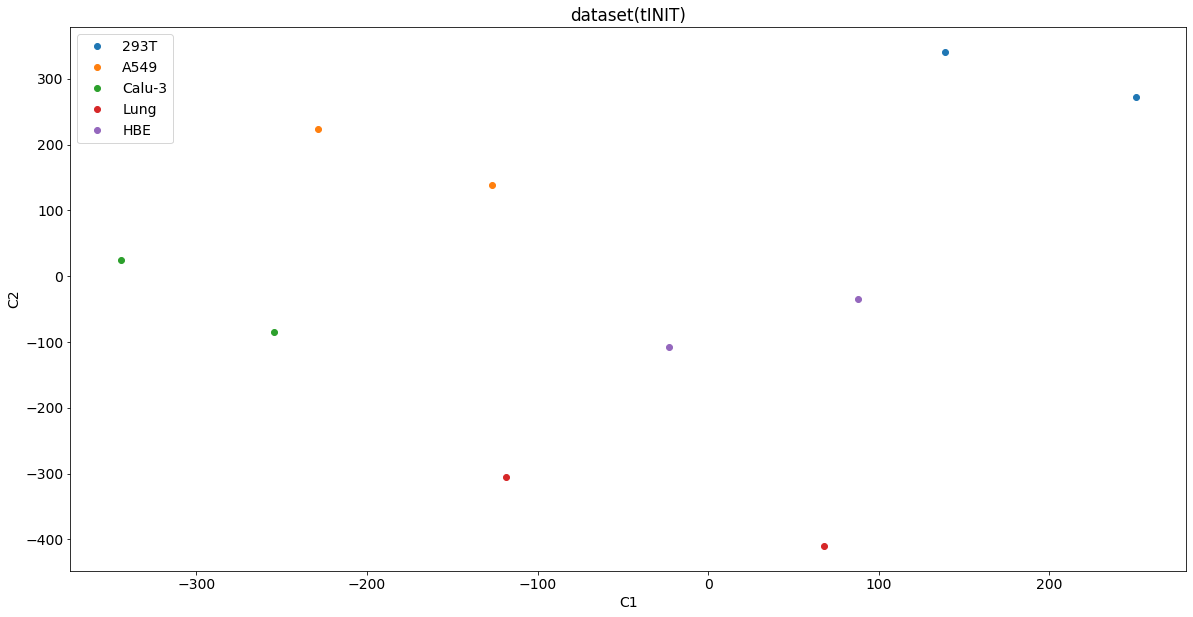

In [32]:
for c in combinations(range(n_components), 2):
    i1 = c[0]
    i2 = c[1]
    for factor in groups:
        for group, models_group in groups[factor].items():                        
            locs = np.isin(model_names, models_group)
            plt.plot(comps[locs,i1], comps[locs,i2],"o", label=group)
            
        #for model, x, y in zip(models, comps[:,i1], comps[:,i2]):        
        #    plt.text(x+0.05,y+0.05,model)

        if selected_MEM:
            plt.title(f'{factor}({selected_MEM})')
        else:
            plt.title(factor)
        plt.xlabel("C"+str(i1+1))#plt.xlabel("PC"+str(i1+1) + " (" + str(round(100*pca_explained[i1],2))+"%)")
        plt.ylabel("C"+str(i2+1))#plt.ylabel("PC"+str(i2+1) + " (" + str(round(100*pca_explained[i2],2))+"%)")
        plt.legend()
        plt.gcf().set_size_inches(20,10)
        plt.savefig("results_PCA\\tSNE_"+label_MEM+"C"+str(i1+1)+'_'+"C"+str(i2+1)+'_'+factor+".pdf", format="pdf", bbox_inches = 'tight')
        #plt.savefig("results_PCA\\tSNE_"+label_MEM+"C"+str(i1+1)+'_'+"C"+str(i2+1)+'_'+factor+".png", format="png", bbox_inches = 'tight')
        plt.show()